In [ ]:
import tensorflow.compat.v1 as tf
tf.enable_eager_execution(tf.ConfigProto(log_device_placement=True))
tf.test.gpu_device_name()

# Load accelData from pickle

import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
# import pca
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, Normalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau


# score imports
from sklearn.metrics import accuracy_score, recall_score, precision_score

# class weight import
from sklearn.utils import class_weight


# open accelData pickle
import pickle
with open('drive/MyDrive/Pickles/accelData.pickle', 'rb') as handle:
    accelData = pickle.load(handle)

# Remove time column from accelData Measurements
accelData['Measurements with Time'] = accelData['Measurements']

for i in range(len(accelData['Measurements'])):
    accelData['Measurements'][i] = accelData['Measurements'][i].iloc[:, 1:]

In [40]:
print(accelData['Abnormal'])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [124]:
from tensorflow.keras.callbacks import TensorBoard
import datetime

#import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import Precision, Recall

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

def window_generator(data, labels, windowSize, stride, batch_size=128):
    while True:  # Loop forever so the generator never terminates

        batch_features = []
        batch_labels = []
        batch_windows = []

        for i in np.random.permutation(len(data)):

            batch_windows.append(data[i])            
            batch_labels.append(labels[i])
        
            if len(batch_windows) == batch_size:

                # normalize the batch
                batch_windows_array = np.array(batch_windows)
                batch_features= vectorized_normalization(batch_windows_array)

                # PCA transform each window in the batch
                #batch_features = PCA.transform(batch_features)

                # Yield the batch data
                yield np.array(batch_windows), np.array(batch_labels)
                batch_features = []
                batch_labels = []

def vectorized_normalization(windows):
    # Compute means and standard deviations for each window
    means = windows.mean(axis=1, keepdims=True)
    stds = windows.std(axis=1, keepdims=True)

    # Normalize
    normalized_windows = (windows - means) / stds

    return normalized_windows

def specificity_score(y_true, y_pred):
    tn = np.sum((y_true == 0) & (y_pred == 0))
    print("True negatives: ", tn)
    fp = np.sum((y_true == 0) & (y_pred != 0))
    print("False positives: ", fp)
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    return specificity

from tensorflow.keras.regularizers import l2

def build_model(input_shape, num_classes):
    l2_value = 0.01  # Example regularization factor for L2 regularization

    model3 = Sequential([
        Normalization(input_shape=input_shape),  # Uncommented and assuming normalization is configured correctly

        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Dropout(0.5),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.5),
        Flatten(),
        
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model2 = Sequential([
        #Normalization(input_shape=input_shape),
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),  # Reduced filters
        MaxPooling1D(pool_size=2),
        Flatten(),  # Removed one Conv1D and one Dropout layer for simplicity
        Dense(64, activation='relu'),  # Reduced the size of the dense layer
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model4 = Sequential([
        Normalization(input_shape=input_shape),  # Uncommented and assuming normalization is configured correctly
        Conv1D(filters=32, kernel_size=3, activation='relu'),  # 'input_shape' is already defined in Normalization
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Flatten(),  # Flattening the convolved features
        
        # Adding PCA-like layer: Dense layer with linear activation (or no activation) right after flattening
        Dense(4, use_bias=False, activation=None),  # 'num_components' defines the reduced dimensionality
        BatchNormalization(),  # Add Batch Normalization after PCA-like layer

        Dense(32, activation='relu'),  # Continuing with the dense layers as before
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model = Sequential([
        Normalization(input_shape=input_shape),
        Conv1D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=l2(l2_value)),  # Add L2 regularization to Conv1D
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Flatten(),
        
        # Adding PCA-like layer
        Dense(4, use_bias=False, activation=None, kernel_regularizer=l2(l2_value)),  # Add L2 regularization to Dense layer
        BatchNormalization(),
        
        Dense(32, activation='relu', kernel_regularizer=l2(l2_value)),  # Add L2 regularization to Dense layer
        Dropout(0.5),
        Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_value))  # Add L2 regularization to output layer
    ])


    model.compile(optimizer=Adam(learning_rate=0.01),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(), Recall()],
                  run_eagerly=False)
    return model

def createWindows(data, windowSize, stride):
    windows = []
    for i in range(0, len(data) - windowSize, stride):
        windows.append(data[i:i+windowSize])
    return windows
    
def batchWindowClassification(trials, labels, windowSize, stride, batch_size=100, verbose=False, percentage=0.25):

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(trials, labels, test_size=0.3, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    if verbose:
        # plot histogram showing distribution of labels
        plt.hist(y_train)
        # title
        plt.title('Distribution of labels in training set')
        plt.show()

        plt.hist(y_test)
        # title
        plt.title('Distribution of labels in testing set')
        plt.show()  

        print(y_train)
        print(y_test)

    unique_labels = np.unique(np.concatenate((y_train, y_test, y_val)))
    num_classes = len(unique_labels)
    if verbose:
        print(f"Number of unique classes: {num_classes}")

    # Prepare labels for training
    encoder = LabelEncoder()
    encoder.fit(np.concatenate((y_train, y_test, y_val)))

    # Split X_train into windows
    trainWindows = []
    trainWindowLabels = []
    for i in range(len(X_train)):
        windows = createWindows(X_train[i], windowSize, stride)
        trainWindows.extend(windows)
        labelArray = np.full(len(windows), y_train[i])
        # Convert labelArray to a list
        trainWindowLabels.extend(labelArray.tolist())

    valWindows = []
    valWindowLabels = []
    for i in range(len(X_val)):
        windows = createWindows(X_val[i], windowSize, stride)
        valWindows.extend(windows)
        labelArray = np.full(len(windows), y_val[i])
        # Convert labelArray to a list
        valWindowLabels.extend(labelArray.tolist())
    
    print(len(trainWindows))

    # encode trainWindowLabels
    encoded_trainWindowLabels = encoder.transform(trainWindowLabels)
    encoded_trainWindowLabels = to_categorical(encoded_trainWindowLabels, num_classes=num_classes)

    # encode valWindowLabels
    encoded_valWindowLabels = encoder.transform(valWindowLabels)
    encoded_valWindowLabels = to_categorical(encoded_valWindowLabels, num_classes=num_classes)

    # Creating generators for training and validation
    train_gen = window_generator(trainWindows, encoded_trainWindowLabels, windowSize, stride, batch_size=batch_size)
    val_gen = window_generator(valWindows, encoded_valWindowLabels, windowSize, stride, batch_size=batch_size)

    # Assuming `y_train` contains the original labels
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = dict(enumerate(class_weights))

    model = build_model((windowSize, 16), 3)

    # Adapting the Normalization layer with a batch of data from the training set
    for X_batch, _ in window_generator(trainWindows, encoded_trainWindowLabels, windowSize, stride, batch_size=128):
        model.layers[0].adapt(X_batch)  # Adapt the normalization layer
        break 

    # Assume your model is named 'model' and is already defined
    model.fit(train_gen, 
        #callbacks=[reduce_lr], 
        validation_data=(np.array(valWindows), encoded_valWindowLabels),
        #validation_split=0.2,
        steps_per_epoch=max(1, len(trainWindows) // batch_size), 
        #steps_per_epoch=100,
        epochs=10, 
        verbose=1)
        #callbacks=[tensorboard_callback]) #, class_weight=class_weights_dict)    

    # Split X_test into windows, ensuring that the windows are segmented by trial
    # Use nested list, where each element is a list of windows from a single trial
    testWindows = []
    testWindowLabels = []
    for i in range(len(X_test)):
        windows = createWindows(X_test[i], windowSize, stride)
        testWindows.append(windows)
        testWindowLabels.append(y_test[i])

    # Encode test window labels
    #encoder = LabelEncoder()
    #encoder.fit(testWindowLabels)
    encodedLabels = encoder.transform(testWindowLabels)
    encodedLabels = to_categorical(encodedLabels)

    # Predict the label of each window using the trained model
    predictions = []
    
    for trial in testWindows:
        trialPredictions = model.predict(np.array(trial))
        predictions.append(trialPredictions)   

    trial_pred = []
    for i in range(len(predictions)):
        normalCount = 0
        borderLineCount = 0
        abnormalCount = 0

        for window in predictions[i]:
            if np.argmax(window) == 0:
                normalCount += 1
            elif np.argmax(window) == 2:
                abnormalCount += 1
            else:
                borderLineCount += 1
              
        # if more than percentage of the windows are classified as abnormal, classify the trial as abnormal
        if abnormalCount / len(predictions[i]) > percentage:
            trial_pred.append(1.0)
        elif borderLineCount / len(predictions[i]) > percentage:
            trial_pred.append(0.5)
        else:
            trial_pred.append(0.0)
            
    # Compare the classification to the true label and calculate the accuracy
    print(trial_pred)
    print(y_test)

    # Calulate accuracy, sensitivity, false positive rate, specificity and precision
    accuracy = (accuracy_score(y_test, trial_pred))
    sensitivity = (recall_score(y_test, trial_pred, average='macro'))
    specificity = (specificity_score(np.array(y_test), np.array(trial_pred)))
    false_positive_rate = (1 - specificity)
    
    precision = (precision_score(y_test, trial_pred, average='macro'))

    results = {'accuracy': accuracy, 'sensitivity': sensitivity, 'false_positive_rate': false_positive_rate, 'specificity': specificity, 'precision': precision}

    print(f'Accuracy: {accuracy}')
    print(f'Sensitivity: {sensitivity}')
    print(f'False Positive Rate: {false_positive_rate}')
    print(f'Specificity: {specificity}')
    print(f'Precision: {precision}')    

    return results, model

In [55]:
accuracy, model = batchWindowClassification(accelData['Measurements'], accelData['Abnormal'], 5000, 2500, batch_size=128, verbose=False)

4388
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When fil

Percentage: 0.1
22491
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFl

Text(0.5, 0, 'Percentage')

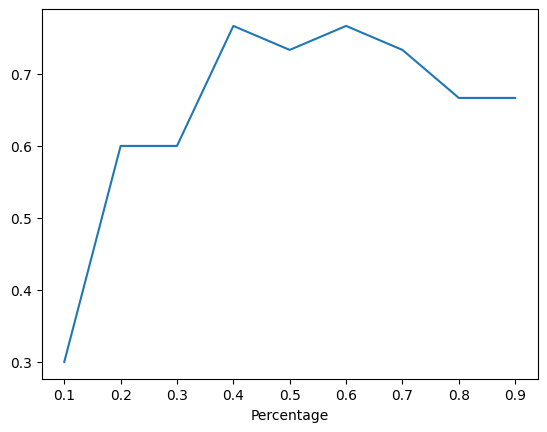

In [59]:
# experiment with different percentages
percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
accuracies = []
for percentage in percentages:
    print(f'Percentage: {percentage}')
    accuracy, model = batchWindowClassification(accelData['Measurements'], accelData['Abnormal'], 1000, 500, batch_size=200, verbose=False, percentage=percentage)
    print(f'Accuracy: {accuracy}')
    accuracies.append(accuracy)

plt.plot(percentages, accuracies)
plt.xlabel('Percentage')

In [61]:
print(accuracies)
print(percentages)

[0.3, 0.6, 0.6, 0.7666666666666667, 0.7333333333333333, 0.7666666666666667, 0.7333333333333333, 0.6666666666666666, 0.6666666666666666]
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


In [80]:
results, model = batchWindowClassification(accelData['Measurements'], accelData['Abnormal'], 1000, 500, batch_size=200, verbose=False, percentage=0.6)

22491
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When fi

In [82]:
results, model = batchWindowClassification(accelData['Measurements'], accelData['Abnormal'], 5000, 2500, batch_size=50, verbose=False, percentage=0.6)

4388
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When fil

In [115]:
results, model = batchWindowClassification(accelData['Measurements'], accelData['Abnormal'], 1000, 500, batch_size=250, verbose=False, percentage=0.6)

22491
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When fi

In [116]:
results, model = batchWindowClassification(accelData['Measurements'], accelData['Abnormal'], 1000, 500, batch_size=150, verbose=False, percentage=0.6)

22491
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When fi

In [125]:
# work out how many batches required for each trial if i want steps per epoch to be 100 (i.e. window number / batch size)
# then use that number to calculate the number of windows to use for each trial
# then use the same number of windows for each trial

results, model = batchWindowClassification(accelData['Measurements'], accelData['Abnormal'], 100, 100, batch_size=500, verbose=False, percentage=0.6)

101448
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When f